# Introduction

This notebook is adapted from a class assignment in NYU's Institute for the Study of the Ancient World "Introduction to Digital Humanities" Fall 2016 Seminar. It is a demonstration of the combination of public data sources, the combination of python pandas and SQL manipulations, and of the potential and limits of visualization in the pursuit of digitally informed historical interpretation.

In [52]:
import gzip            # can uncompress gzipped files, useful for accessing the pleiades data
import io              # useful routines for input/output
import pandas as pd    # for working with "rows/columns" oriented data
import sqlite3         # an SQL database
import urllib.request  # for loading documents using http

%matplotlib inline

import matplotlib # plotting
import matplotlib.pyplot as plt

# load csv files
ramphs = pd.read_csv("https://raw.githubusercontent.com/sfsheath/roman-amphitheaters/master/roman-amphitheaters.csv")
chronogrps = pd.read_csv("https://raw.githubusercontent.com/sfsheath/roman-amphitheaters/master/chronogrps.csv")

# load gzipped pleiades. key is "io.BytesIO(gzip.decompress(response.read())", which 
# delivers (so to speak) an uncompressed csv to 'pd.read_csv'.
response = urllib.request.urlopen("http://atlantides.org/downloads/pleiades/dumps/pleiades-places-latest.csv.gz")
pleiades = pd.read_csv(io.BytesIO(gzip.decompress(response.read())))

# One note: because it takes a long time to load the pleiades data,
# avoid running this cell again unless necessary

In [53]:
# The conn variable is a 'database connection'
# we are making this database in memory, meaning it won't be saved
conn = sqlite3.connect(':memory:')

In [54]:
# first load of pandas DataFrames into SQL database
ramphs.to_sql('ramphs',conn,if_exists="replace")
chronogrps.to_sql('chronogrps', conn, if_exists="replace")
pleiades.to_sql('pleiades', conn, if_exists ="replace")

# Plot mean difference in Amphitheater by Modern Country

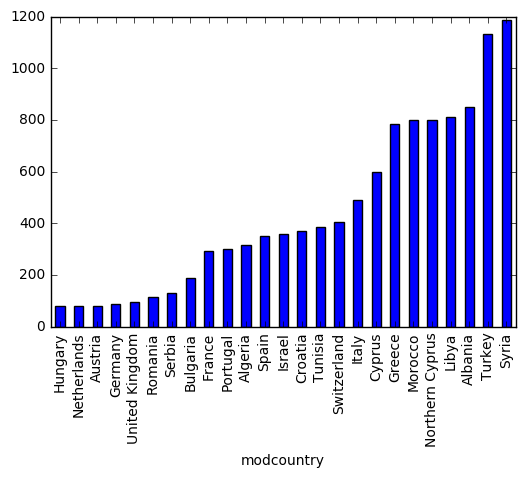

In [55]:
# make pleiades id values compatible and reload ramphs into sql table
ramphs['pleiadesid'] = ramphs['pleiades'].str.replace('http://pleiades.stoa.org/places/','')
ramphs.to_sql('ramphs', conn, if_exists='replace')

# SQL SELECT statement to bring data together
combined = pd.read_sql("""SELECT ramphs.id,
                                 ramphs.chronogrp,
                                 ramphs.modcountry,
                                 chronogrps.start,
                                 pleiades.minDate
  FROM ramphs, chronogrps, pleiades
  WHERE (ramphs.chronogrp = chronogrps.chronogrp) and (ramphs.pleiadesid = pleiades.id)
  ORDER BY chronogrps.start""",conn)

# Calculate difference from start of settlement to construction of amphitheater
combined['difference'] = combined['start'] - combined['minDate']

# Group that info into mean by country
grouped = combined.groupby('modcountry')['difference'].mean()

# Plot after sorting by mean difference
grouped.sort_values().plot.bar()

# The resulting chart shows the mean difference between earliest date that Pleiades 
# provides for settlements and amphitheater construction by modern country. As always, such a 
# visualization does not provide "an answer". It is firstly influenced by the
# granularity of the amphitheater and pleiades data, both of which have a simplified
# chronological model. The visualization itself obscures underlying aspects such as the
# very much greater number of amphitheaters in Italy as opposed to Syria. But within
# the context of a broader understanding of long-term historical trends in the Mediterranean
# World and Europe, there are correlations to be made with the history of large-scale
# urbanization and settlement continuity. There are also oddities: Israel stands out so that an
# obvious next step is to explore individual amphitheater-city pairings within each group.